# Simple SBML example


This notebook creates a simple model in [SBML version 3 level 1](https://synonym.caltech.edu/documents/specifications/level-3/version-1/core/release-3/) for illustration.  We then use [BasiCO](https://basico.readthedocs.io/en/latest/) to build and run a simulation of the SBML model.  BasiCO is a simplified interface to using COPASI from python.

## 1) Including libraries

In [16]:
import os
import libsbml
from combine_notebooks import RESULTS_DIR
from basico import load_model, run_time_course, get_reaction_parameters, get_species
from combine_notebooks.validation.validation_sbml import validate_sbml

## 2) Declaring the SBML model

Create an empty SBMLDocument object.  It's a good idea to check for
possible errors.  Even when the parameter values are hardwired like
this, it is still possible for a failure to occur (e.g., if the
operating system runs out of memory).

In [17]:
try:
    document = libsbml.SBMLDocument(3, 1)
except ValueError:
    raise SystemExit('Could not create SBMLDocument object')

Create the basic Model object inside the SBMLDocument object.  To
produce a model with complete units for the reaction rates, we need
to set the 'timeUnits' and 'extentUnits' attributes on Model.  We
set 'substanceUnits' too, for good measure, though it's not strictly
necessary here because we also set the units for individual species
in their definitions.

In [18]:
model = document.createModel()
model.setTimeUnits("second")
model.setExtentUnits("mole")
model.setSubstanceUnits('mole')

0

Create a unit definition we will need later.  Note that SBML Unit
objects must have all four attributes 'kind', 'exponent', 'scale'
and 'multiplier' defined.

In [19]:
per_second = model.createUnitDefinition()
per_second.setId('per_second')
unit = per_second.createUnit()
unit.setKind(libsbml.UNIT_KIND_SECOND)
unit.setExponent(-1)
unit.setScale(0)
unit.setMultiplier(1)

0

Create a compartment inside this model, and set the required
attributes for an SBML compartment in SBML Level 3.

In [20]:
c1 = model.createCompartment()
c1.setId('c1')
c1.setConstant(True)
c1.setSize(1)
c1.setSpatialDimensions(3)
c1.setUnits('litre')

0

Create two species inside this model, set the required attributes
for each species in SBML Level 3 (which are the 'id', 'compartment',
'constant', 'hasOnlySubstanceUnits', and 'boundaryCondition'
attributes), and initialize the amount of the species along with the
units of the amount.

In [21]:
s1 = model.createSpecies()
s1.setId('S1')
s1.setCompartment('c1')
s1.setConstant(False)
s1.setInitialAmount(5)
s1.setSubstanceUnits('mole')
s1.setBoundaryCondition(False)
s1.setHasOnlySubstanceUnits(False)

s2 = model.createSpecies()
s2.setId('S2')
s2.setCompartment('c1')
s2.setConstant(False)
s2.setInitialAmount(0)
s2.setSubstanceUnits('mole')
s2.setBoundaryCondition(False)
s2.setHasOnlySubstanceUnits(False)

0

Create a parameter object inside this model, set the required
attributes 'id' and 'constant' for a parameter in SBML Level 3, and
initialize the parameter with a value along with its units.

In [22]:
k = model.createParameter()
k.setId('k')
k.setConstant(True)
k.setValue(1)
k.setUnits('per_second')

0

Create a reaction inside this model, set the reactants and products,
and set the reaction rate expression (the SBML "kinetic law").  We
set the minimum required attributes for all of these objects.  The
units of the reaction rate are determined from the 'timeUnits' and
'extentUnits' attributes on the Model object.

In [23]:
r1 = model.createReaction()
r1.setId('r1')
r1.setReversible(False)
r1.setFast(False)

species_ref1 = r1.createReactant()
species_ref1.setSpecies('S1')
species_ref1.setConstant(True)

species_ref2 = r1.createProduct()
species_ref2.setSpecies('S2')
species_ref2.setConstant(True)

math_ast = libsbml.parseL3Formula('k * S1 * c1')

kinetic_law = r1.createKineticLaw()
kinetic_law.setMath(math_ast)

0

## 3) Write, print and validate the generated model

And we're done creating the basic model.  Here we will check if the SBML is valid.

In [25]:
# validate file
validate_sbml(document, units_consistency=False)

--------------------------------------------------------------------------------
validation error(s)      : 0
validation warning(s)    : 0
--------------------------------------------------------------------------------


Now save a text string containing the model into an XML file.

In [26]:
file_loc = str(RESULTS_DIR) + "/hello_world_sbml.xml"
os.makedirs(os.path.dirname(file_loc), exist_ok=True)
libsbml.writeSBMLToFile(document, file_loc)
xml = open(file_loc).read()
print(xml)

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model substanceUnits="mole" timeUnits="second" extentUnits="mole">
    <listOfUnitDefinitions>
      <unitDefinition id="per_second">
        <listOfUnits>
          <unit kind="second" exponent="-1" scale="0" multiplier="1"/>
        </listOfUnits>
      </unitDefinition>
    </listOfUnitDefinitions>
    <listOfCompartments>
      <compartment id="c1" spatialDimensions="3" size="1" units="litre" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="c1" initialAmount="5" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="c1" initialAmount="0" substanceUnits="mole" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="k" value="1" units="per_second" cons

## 4) Simulating the model

Now we will load to model into COPASI (basico) so we can run a simulation.

In [27]:
model = load_model(file_loc)

To verify our species parameters for s1 and s2 we can call get_species, which returns a dataframe with all information about the species.

In [28]:
get_species()

compartment       type   unit  initial_concentration  \
name                                                        
S1            c1  reactions  mol/l                    5.0   
S2            c1  reactions  mol/l                    0.0   

      initial_particle_number initial_expression expression  concentration  \
name                                                                         
S1               3.011071e+24                                          5.0   
S2               0.000000e+00                                          0.0   

      particle_number  rate  particle_number_rate           key sbml_id  
name                                                                     
S1       3.011071e+24  -5.0         -3.011071e+24  Metabolite_0      S1  
S2       0.000000e+00   5.0          3.011071e+24  Metabolite_1      S2

To see the kinetic paramters of our recation we can use get_reaction_parameters.

In [29]:
get_reaction_parameters()

value reaction    type mapped_to
name                                     
(r1).k1    1.0       r1  global         k

Now lets simulate our model for 10 seconds.

<AxesSubplot: xlabel='Time'>

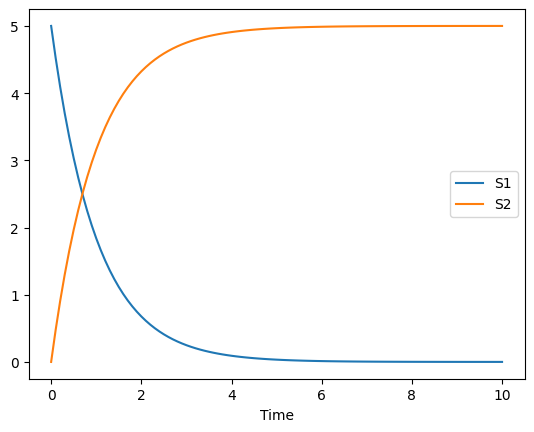

In [30]:
result = run_time_course(duration=10)
result.plot()